In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from snAPI.Main import *
import pandas as pd
sys.path.append("../")
from HH import HH_T3
from Functions import *
import time

# Functions

In [2]:
def getcols(m1,nrows):
    arr=np.array([])
    for elem in np.cumsum(m1):
        rest=elem%(nrows)
        inte=elem//(nrows)
        if inte%2==1:
            a=nrows-rest
        else:
            a=rest 
        arr=np.append(arr,a)       
    return arr

f=lambda x : nrows-x%(nrows) if x//(nrows)%2==1 else x%(nrows) # this is the lambda version of getcols (much faster)

In [3]:
def positions(df,step):
    xs=np.unique(df['row'])*step
    ys=np.unique(df['col'])*step
    return xs,ys
    

# Select file

In [4]:
filename='../../../Acquisition2/Data/Violet/Images/PTU_15.0_25.0_30_-5.0_5.0_30.ptu'
os.listdir(filename)

NotADirectoryError: [WinError 267] El nombre del directorio no es válido: '../../../Acquisition2/Data/Violet/Images/PTU_15.0_25.0_30_-5.0_5.0_30.ptu'

# Create data structure 

In [5]:
sn=snAPI()
sn.getDevice()
sn.getFileDevice(filename)
sn.initDevice(MeasMode.T3)
sn.unfold.setT3Format(format=UnfoldFormat.DTimesSyncCntr)
sn.unfold.measure()
tres=sn.deviceConfig['Resolution']/1000
times, channels = sn.unfold.getBlock()
dtimes=sn.unfold.dTime_T3(times)*tres
absTimes=times*tres
markers_Bool=np.array([sn.unfold.isMarker(datai) for datai in channels])
m1=markers_Bool*sn.unfold.markers(channels)[2]
m2=markers_Bool*sn.unfold.markers(channels)[3]
m3=markers_Bool*sn.unfold.markers(channels)[1]


In [6]:
cum=np.cumsum(markers_Bool)
rm=np.array([n%2 for n in cum])
row=np.array(np.cumsum(m2),dtype=int)
df=pd.DataFrame(np.array([dtimes,absTimes,channels,markers_Bool,m1,m2,m3,rm]).T,columns=['dTimes','absTimes','Channels','markers','m1','m2','m3','rm'])
df['row']=row
nrows=np.sum(df['m1'][df['row']==2])
col=np.array([f(x) for x in np.cumsum(m1)],dtype=int)
df['col']=col

In [7]:

df['cm3']=np.cumsum(df['m3'])
data= df[df['rm'] !=0]
data=data[data['Channels']==3]
data=data[data['cm3']!=0]#remove data before starting measurement (data start after the first m3 marker)
data=data.drop(columns=['m1', 'm2','m3','markers','rm'])

# X Y positions: ROW an COLs

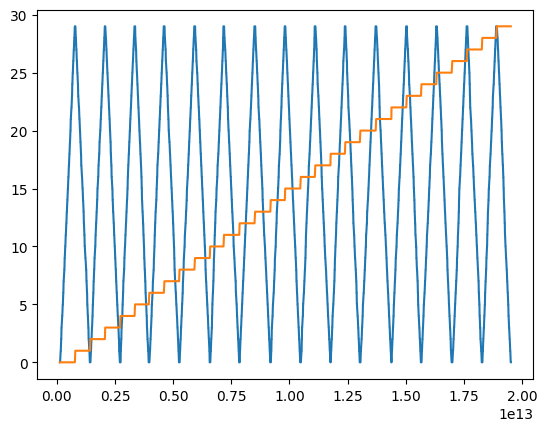

In [8]:
plt.plot(data['absTimes'],data['col'])
plt.plot(data['absTimes'],data['row'])

# Reconstruct image

In [9]:
xs=np.unique(df['row'])
ys=np.unique(df['col'])
M=np.zeros((np.size(xs),np.size(ys)))
for xi in xs:
    for yi in ys:
        M[xi,yi]=np.size(data['dTimes'][(data['row']==xi)&(data['col']==yi)])
M[0,0]=M[0,1]
#M=np.array([[np.size(data['dTimes'][(data['row']==xi)&(data['col']==yi)]) for xi in xs] for yi in ys])

In [10]:
x,y=positions(df,0.2)

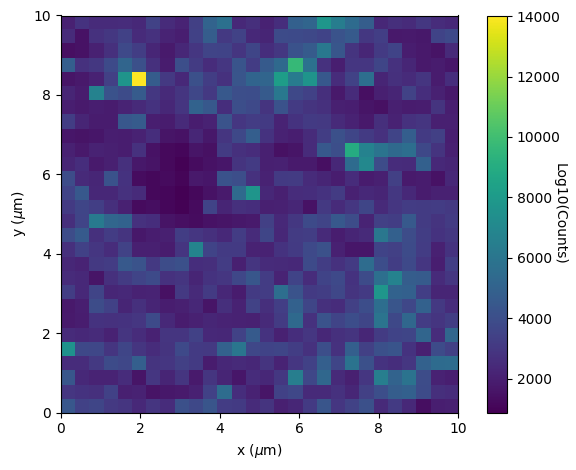

In [11]:
plt.imshow(M[1:-1,1:-1],extent=[0,10,0,10])
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
cbar=plt.colorbar()
cbar.set_label('Log10(Counts)', rotation=270)
plt.tight_layout()

## FLIM

In [12]:
from scipy.optimize import curve_fit
def binned(times,t_res, t0, tf):
        edges=np.arange(t0,tf,t_res)
        return np.histogram(times,edges)
def edges2bins(edges):
    return edges[:-1]+np.diff(edges)/2
def model1(x,alpha,tau,B):
    return np.log10(alpha*np.exp(-(x)/tau)+B)
def model2(x,t0,alpha1,tau1,alpha2,tau2,B):
    return np.log10(alpha1*np.exp(-(x-t0)/tau1)+alpha2*np.exp(-(x-t0)/tau2)+B)
def model3(x,t0,alpha1,tau1,alpha2,tau2,alpha3,tau3,B):
    return np.log10(alpha1*np.exp(-(x-t0)/tau1)+alpha2*np.exp(-(x-t0)/tau2+alpha3*np.exp(-(x-t0)/tau3))+B)
def model2(x,alpha1,tau1,alpha2,tau2,B):
    return np.log10(alpha1*np.exp(-(x)/tau1)+alpha2*np.exp(-(x)/tau2)+B)

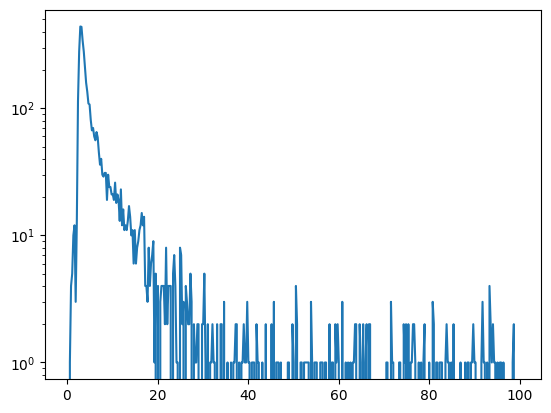

In [13]:
binning=1
off=42
win=100
d=data[(data['row']==0)&(data['col']==2)]
dt=(d['dTimes']+off)%win #change offset
countsf0,edges0=binned(dt,tres*binning,0,100)
bins0=edges2bins(edges0)
plt.plot(bins0,countsf0)
plt.yscale('log')

In [14]:
n0=10
xdata0=bins0[n0:]
ydata0=np.log10(countsf0[n0:])
valid = ~(np.isinf(xdata0) | np.isinf(ydata0))
xdata=xdata0[valid]
ydata=ydata0[valid]


C:\Users\NEXT-BOLD\AppData\Local\Temp\ipykernel_8528\2286385017.py:3: RuntimeWarning: divide by zero encountered in log10
  ydata0=np.log10(countsf0[n0:])


C:\Users\NEXT-BOLD\AppData\Local\Temp\ipykernel_8528\4277638075.py:14: RuntimeWarning: invalid value encountered in log10
  return np.log10(alpha1*np.exp(-(x)/tau1)+alpha2*np.exp(-(x)/tau2)+B)


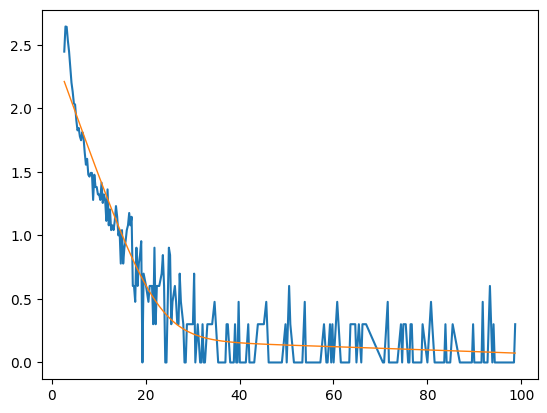

In [15]:
popt, pcov = curve_fit(f=model2,xdata=xdata,ydata=ydata,p0=(300,40.0,10.0,2000,5))
plt.plot(xdata,ydata)
fit=model2(xdata,popt[0],popt[1],popt[2],popt[3],popt[4])
plt.plot(xdata,fit,label=('\u03b11={:.2f}\n\u03b12 ={:.2f}\n\u03c41={:.2f}ns\n\u03c42={:.2f}ns\nB={:.2f}:'.format(popt[0],popt[2],popt[1],popt[3],popt[4])),linewidth=1)

In [16]:
xs=np.unique(df['row'])
ys=np.unique(df['col'])
tau1=np.zeros((np.size(xs),np.size(ys)))
alpha1=np.zeros((np.size(xs),np.size(ys)))
tau2=np.zeros((np.size(xs),np.size(ys)))
alpha2=np.zeros((np.size(xs),np.size(ys)))
bck=np.zeros((np.size(xs),np.size(ys)))
for xi in xs:
    for yi in ys:
        d=data[(data['row']==xi)&(data['col']==yi)]
        dt=(d['dTimes']+off)%win #change offset
        countsf0,edges0=binned(dt,tres*binning,0,100)
        bins0=edges2bins(edges0)
        xdata0=bins0[n0:]
        ydata0=np.log10(countsf0[n0:])
        valid = ~(np.isinf(xdata0) | np.isinf(ydata0))
        xdata=xdata0[valid]
        ydata=ydata0[valid]
        popt, pcov = curve_fit(f=model2,xdata=xdata,ydata=ydata,p0=(100,10.0,100.0,5,5))
        tau1[xi,yi]=popt[1]
        tau2[xi,yi]=popt[3]
        alpha1[xi,yi]=popt[0]
        alpha2[xi,yi]=popt[2]
        bck[xi,yi]=popt[4]
M[0,0]=M[0,1]
#M=np.array([[np.size(data['dTimes'][(data['row']==xi)&(data['col']==yi)]) for xi in xs] for yi in ys])

C:\Users\NEXT-BOLD\AppData\Local\Temp\ipykernel_8528\3599595733.py:15: RuntimeWarning: divide by zero encountered in log10
  ydata0=np.log10(countsf0[n0:])
C:\Users\NEXT-BOLD\AppData\Local\Temp\ipykernel_8528\4277638075.py:14: RuntimeWarning: invalid value encountered in log10
  return np.log10(alpha1*np.exp(-(x)/tau1)+alpha2*np.exp(-(x)/tau2)+B)
C:\Users\NEXT-BOLD\AppData\Local\Temp\ipykernel_8528\4277638075.py:14: RuntimeWarning: overflow encountered in exp
  return np.log10(alpha1*np.exp(-(x)/tau1)+alpha2*np.exp(-(x)/tau2)+B)
C:\Users\NEXT-BOLD\AppData\Local\Temp\ipykernel_8528\4277638075.py:14: RuntimeWarning: overflow encountered in multiply
  return np.log10(alpha1*np.exp(-(x)/tau1)+alpha2*np.exp(-(x)/tau2)+B)
c:\Users\NEXT-BOLD\anaconda3\envs\HydraHarp\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

Text(0, 0.5, 'y ($\\mu$m)')

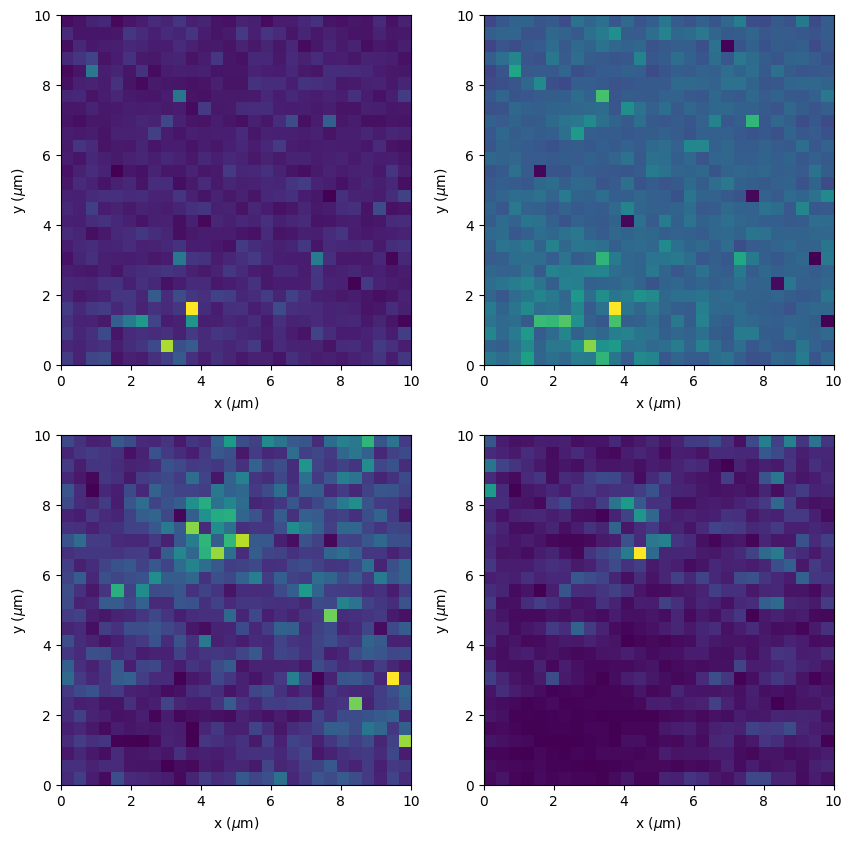

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(tau1[1:-1,1:-1],extent=[0,10,0,10])
ax[0,0].set_xlabel('x ($\mu$m)')
ax[0,0].set_ylabel('y ($\mu$m)')
ax[0,1].imshow(tau2[1:-1,1:-1],extent=[0,10,0,10])
ax[0,1].set_xlabel('x ($\mu$m)')
ax[0,1].set_ylabel('y ($\mu$m)')
ax[1,0].imshow(alpha1[1:-1,1:-1],extent=[0,10,0,10])
ax[1,0].set_xlabel('x ($\mu$m)')
ax[1,0].set_ylabel('y ($\mu$m)')
ax[1,1].imshow(alpha2[1:-1,1:-1],extent=[0,10,0,10])
ax[1,1].set_xlabel('x ($\mu$m)')
ax[1,1].set_ylabel('y ($\mu$m)')


# Analyze line

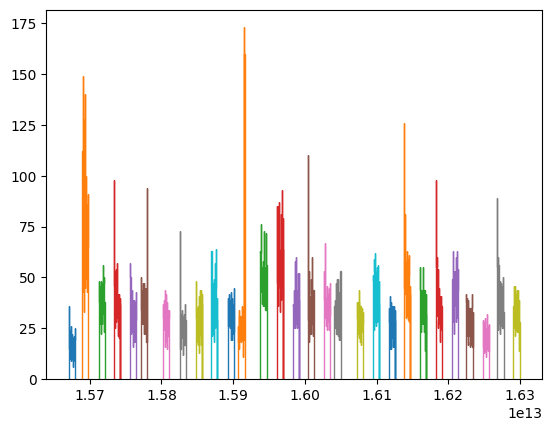

In [57]:
l=24
for i in range (int(nrows)):
    d=data[(data['row']==l)&(data['col']==i)]
    plt.hist(d['absTimes'],bins=100,histtype=u'step')
plt.yscale('linear')
    

# Analyze individual pixel

In [68]:
d=data[(data['row']==24)&(data['col']==11)]

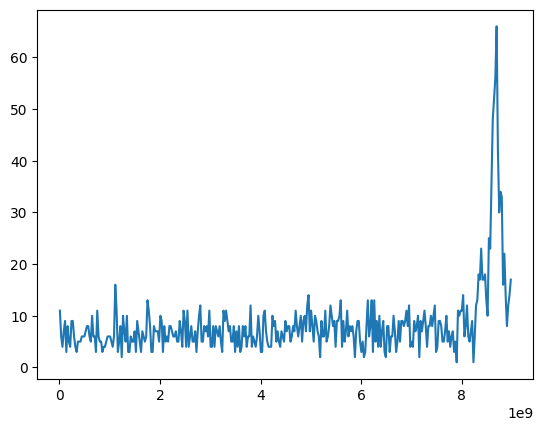

In [70]:
binning=1e8
x=(d['absTimes']-np.array(d['absTimes'])[0])
counts,edges=binned(x,tres*binning,0,0.9e10)
bins0=edges2bins(edges)
plt.plot(bins0,counts)


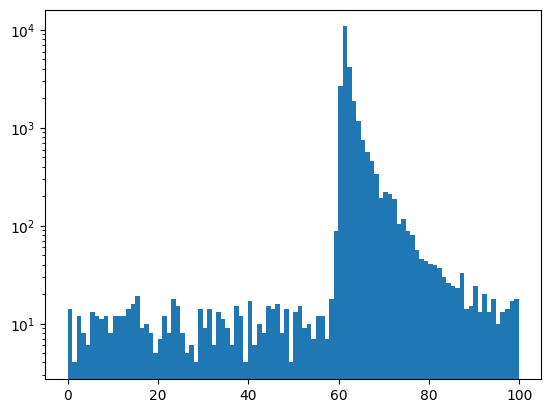

In [371]:
plt.hist(d['dTimes'],bins=100);
plt.yscale('log')

In [315]:
x

8552142    0.000000e+00
8552143    3.774877e+06
8552144    3.984586e+06
8552145    1.185310e+07
8552146    1.845494e+07
               ...     
8560042    3.439432e+10
8560043    3.440025e+10
8560044    3.440218e+10
8560045    3.440544e+10
8560046    3.440645e+10
Name: absTimes, Length: 7905, dtype: float64